# Hacer

- Separar día/mes de fecha [DONE]
- Codificar variables categóricas [DONE]
- Métricas: accuracy, recall y matriz de confusión 
- Borrar regresión lineal porque no sirve

### Definiciones

- Encoding de etiquetas: Día de la semana, se puede ordenar
- Binary encoding: Resto

## Usar

- Regresión lineal
- Árbol de decisión

https://chatgpt.com/share/671b97fb-7904-8006-853c-7d28072ea3c5

- Algún método no supervisado?

In [7]:
# Librerías estándar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Preprocesamiento y división de datos
from sklearn.model_selection import train_test_split
# Modelos de aprendizaje automático
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text, plot_tree

# Métricas de evaluación
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
# Codificación de variables categóricas
import category_encoders as ce

from sklearn.decomposition import PCA

In [8]:
# Función para procesar los dataset
def procesar_dataset(filepath):
    # Carga del dataset
    dataset = pd.read_csv(filepath)

    # Se eliminan las filas que contienen "Otros" en la columna "tipo_cobro"
    # Se toma esta decisión porque su impacto es mínimo
    dataset = dataset[dataset["tipo_cobro"] != "Otros"]

    # Se separa el día y el mes del año en columnas separadas
    # Necesitamos que las variables sean numéricas
    dataset["nro_dia"] = pd.to_datetime(dataset["fecha"]).dt.day
    dataset["nro_mes"] = pd.to_datetime(dataset["fecha"]).dt.month
    dataset["anio"] = pd.to_datetime(dataset["fecha"]).dt.year
    dataset.drop("fecha", axis=1, inplace=True)

    # Se codifica la categoría día de la semana con label encoding (codificación de etiquetas)
    # Se toma esta decisión porque la variable es ordinal
    day_encoding = {
        'Lunes': 0,
        'Martes': 1,
        'Miercoles': 2,
        'Jueves': 3,
        'Viernes': 4,
        'Sabado': 5,
        'Domingo': 6
    }

    dataset['dia_semana'] = dataset['dia'].map(day_encoding)
    dataset.drop("dia", axis=1, inplace=True)

    # Se codifica el resto de las variables categóricas con binary encoding (codificación binaria)
    binary_encoder = ce.BinaryEncoder(cols=["id_peaje", "sentido", "tipo_vehiculo", "tipo_cobro"])
    dataset = binary_encoder.fit_transform(dataset)
    # Eliminamos las columnas sentido_1 y tipo_vehiculo_1 porque no aportan información
    dataset.drop(["sentido_1", "tipo_vehiculo_1"], axis=1, inplace=True)
    # Cambiarle el nombre a las columnas sentido y tipo_vehículo para saber qué significa cada valor
    dataset.rename(columns={'sentido_0': 'hacia_provincia'}, inplace=True)
    dataset.rename(columns={'tipo_vehiculo_0': 'es_pesado'}, inplace=True)
    return dataset

In [9]:
# Función para graficar los resultados de un modelo entrenado
def graph_predictions(y_test, y_pred):
    # Evaluar el modelo
    mse = pow(root_mean_squared_error(y_test, y_pred), 2)
    print("Error cuadrático medio:", mse)

    # Raíz del Error Cuadrático Medio (RMSE - Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # Error Absoluto Medio (MAE - Mean Absolute Error)
    mae = mean_absolute_error(y_test, y_pred)

    # R² (Coeficiente de Determinación):
    r2 = r2_score(y_test, y_pred)

    # Error Absoluto Medio Porcentual (MAPE - Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Imprimir las métricas
    print("Raíz del Error Cuadrático Medio (RMSE):", rmse)
    print("Error Absoluto Medio (MAE):", mae)
    print("Coeficiente de Determinación (R²):", r2)
    print("Error Absoluto Medio Porcentual (MAPE):", mape)


    plt.scatter(y_test, y_pred)
    #plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Línea de identidad
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Gráfico de Dispersión: Valores Reales vs Predicciones')
    plt.show()

    # Gráfico de Residuos (Residual Plot). Muestra los residuos (diferencias entre los valores reales y las predicciones) en función de las predicciones.
    residuals = y_test - y_pred

    plt.scatter(y_pred, residuals)
    #plt.axhline(y=0, color='r', linestyle='--')  # Línea en y=0
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Gráfico de Residuos')
    plt.show()

# Carga del dataset

In [10]:
dataset = procesar_dataset("clean_data.csv")
dataset.sample(10)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473491 entries, 0 to 4473490
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   hora             float64
 1   id_peaje_0       int64  
 2   id_peaje_1       int64  
 3   id_peaje_2       int64  
 4   hacia_provincia  int64  
 5   es_pesado        int64  
 6   tipo_cobro_0     int64  
 7   tipo_cobro_1     int64  
 8   tipo_cobro_2     int64  
 9   tipo_cobro_3     int64  
 10  pasos            int64  
 11  nro_dia          int32  
 12  nro_mes          int32  
 13  anio             int32  
 14  dia_semana       int64  
dtypes: float64(1), int32(3), int64(11)
memory usage: 460.8 MB


Se carga el dataset y se lo divide en datos de test y datos de train

In [11]:
# Dividir en variables predictoras (X) y variable objetivo (y)
x = dataset[['hora', 'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 'hacia_provincia', 'es_pesado', 'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3', 'nro_dia', 'nro_mes', 'anio', 'dia_semana']]  
y = dataset['pasos'] 

# Dividir en conjunto de entrenamiento y de prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

# Regresión lineal

In [12]:
# Instanciar el modelo
linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)

# Evaluar el modelo
mse = root_mean_squared_error(y_test, y_pred) ** 2
print("Error cuadrático medio de la regresión lineal múltiple:", mse)


Error cuadrático medio de la regresión lineal múltiple: 182731.52568192163


## Métricas del modelo

Error cuadrático medio: 182731.52568192163
Raíz del Error Cuadrático Medio (RMSE): 427.47108169082225
Error Absoluto Medio (MAE): 239.10204929707726
Coeficiente de Determinación (R²): 0.1804188597959432
Error Absoluto Medio Porcentual (MAPE): 3264.8196631488304


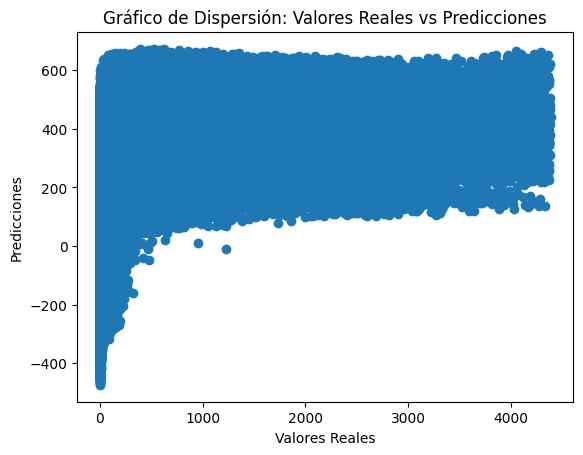

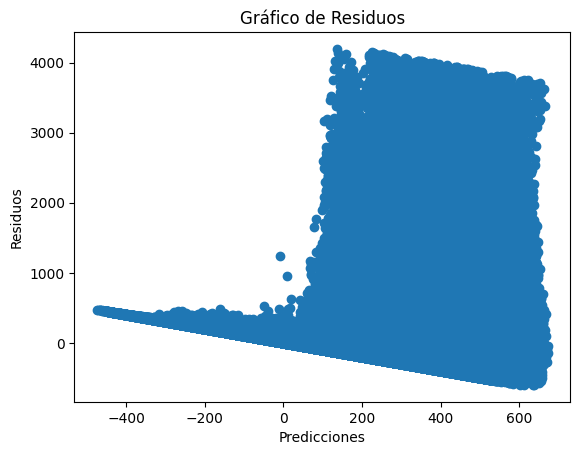

In [13]:
graph_predictions(y_test, y_pred)

## Predicción del modelo respecto al 2024

In [14]:
### TEST DATASET 2024 ###
# Cargar los datos desde los archivos
dataset_train = procesar_dataset("clean_data.csv")
dataset_test = procesar_dataset("2024_data.csv")

# Separar las variables predictoras (X) y la variable objetivo (y) para el conjunto de entrenamiento
x_train = dataset_train[['hora', 'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 'hacia_provincia', 'es_pesado', 
                         'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3',
                         'nro_dia', 'nro_mes', 'anio', 'dia_semana']]  
y_train = dataset_train['pasos']

# Separar las variables predictoras (X) y la variable objetivo (y) para el conjunto de prueba
x_test = dataset_test[['hora', 'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 'hacia_provincia', 'es_pesado',
                       'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3',
                       'nro_dia', 'nro_mes', 'anio', 'dia_semana']]  
y_test = dataset_test['pasos']
x_test.dropna(inplace=True)
y_test = y_test[x_test.index]
linear_model = LinearRegression(positive=True)

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)


C:\Users\Guadalupe\AppData\Local\Temp\ipykernel_7980\2839982296.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test.dropna(inplace=True)


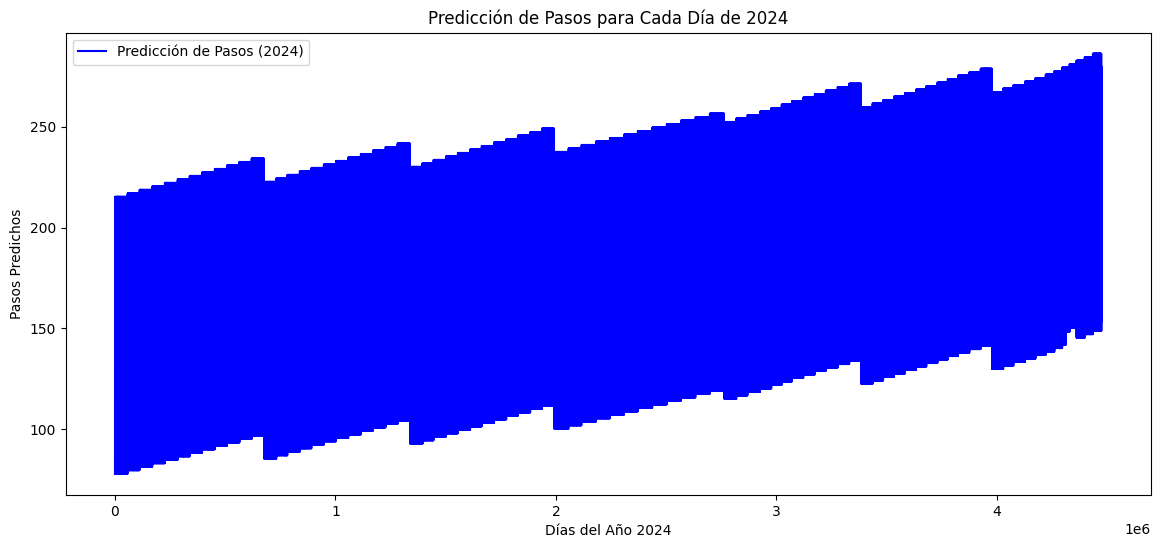

c:\Users\Guadalupe\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


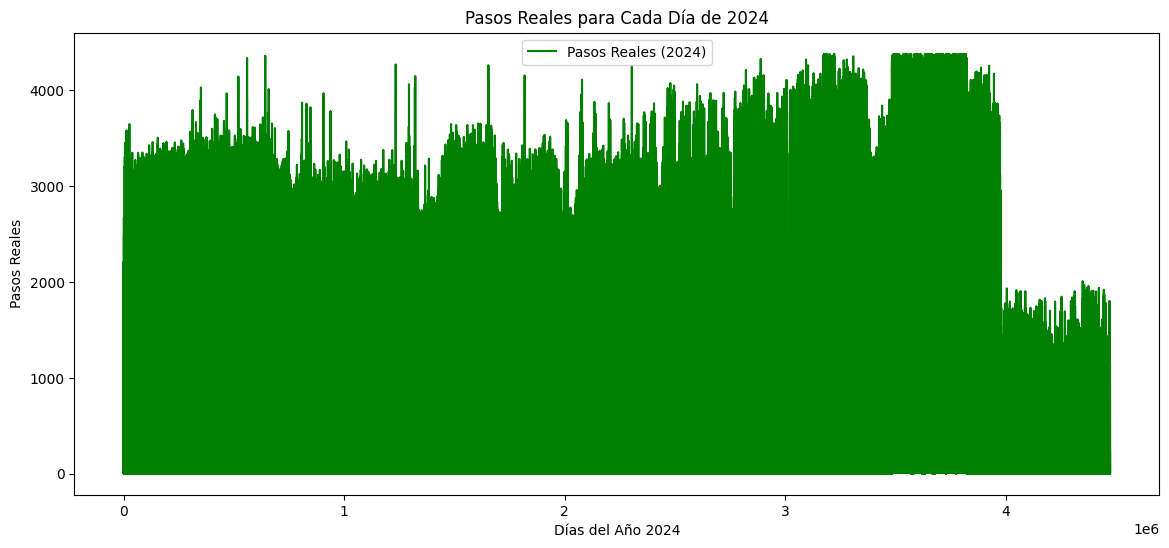

Error Cuadrático Medio (MSE) en 2024: 221188.75542317532
Error Absoluto Medio (MAE) en 2024: 250.1811540305792


In [15]:
# TODO HAY ALGO MAL PORQUE ME DIERON EXACTAMENTE IGUAL

dataset_2024 = procesar_dataset("2024_data.csv")
# Se eliminan algunos nulos que hayan quedado
dataset_2024 = dataset.dropna()

# Separar las variables predictoras (X) y la variable objetivo (y)
x_2024 = dataset_2024[['hora', 'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 'hacia_provincia', 'es_pesado', 'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 
                       'tipo_cobro_3', 'nro_dia', 'nro_mes', 'anio', 'dia_semana']]  
y_real_2024 = dataset_2024['pasos']

# Realizar las predicciones para cada día del 2024 usando el modelo entrenado previamente
y_pred_2024 = linear_model.predict(x_2024)

# Visualización de las predicciones
plt.figure(figsize=(14, 6))
plt.plot(y_pred_2024, label="Predicción de Pasos (2024)", color='blue')
plt.title("Predicción de Pasos para Cada Día de 2024")
plt.xlabel("Días del Año 2024")
plt.ylabel("Pasos Predichos")
plt.legend()
plt.show()

# Visualización de los datos reales del 2024
plt.figure(figsize=(14, 6))
plt.plot(y_real_2024.values, label="Pasos Reales (2024)", color='green')
plt.title("Pasos Reales para Cada Día de 2024")
plt.xlabel("Días del Año 2024")
plt.ylabel("Pasos Reales")
plt.legend()
plt.show()

# Evaluación del modelo para el 2024
mse_2024 = pow(root_mean_squared_error(y_real_2024, y_pred_2024), 2)
mae_2024 = mean_absolute_error(y_real_2024, y_pred_2024)
print(f"Error Cuadrático Medio (MSE) en 2024: {mse_2024}")
print(f"Error Absoluto Medio (MAE) en 2024: {mae_2024}")

# Random forest

In [16]:
# Instanciar y entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(x_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_model.predict(x_test)

# Evaluar el modelo
mse_rf = pow(root_mean_squared_error(y_test, y_pred_rf), 2)
print("Error cuadrático medio de Random Forest:", mse_rf)

Error cuadrático medio de Random Forest: 1468.098489479469


Error cuadrático medio: 1468.098489479469
Raíz del Error Cuadrático Medio (RMSE): 38.3157733770241
Error Absoluto Medio (MAE): 9.818453865225168
Coeficiente de Determinación (R²): 0.9934044516520397
Error Absoluto Medio Porcentual (MAPE): 19.864706133793824


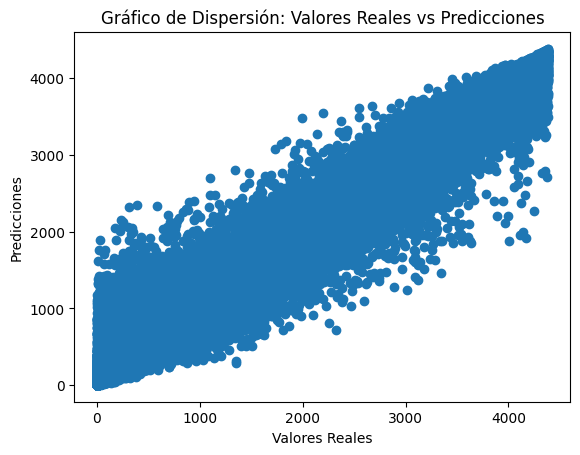

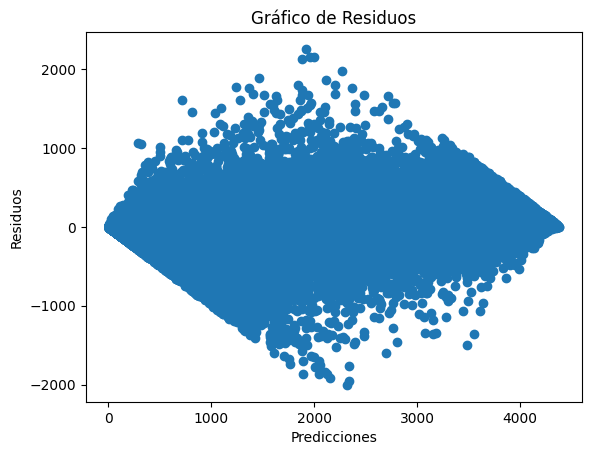

In [17]:
graph_predictions(y_test, y_pred_rf)

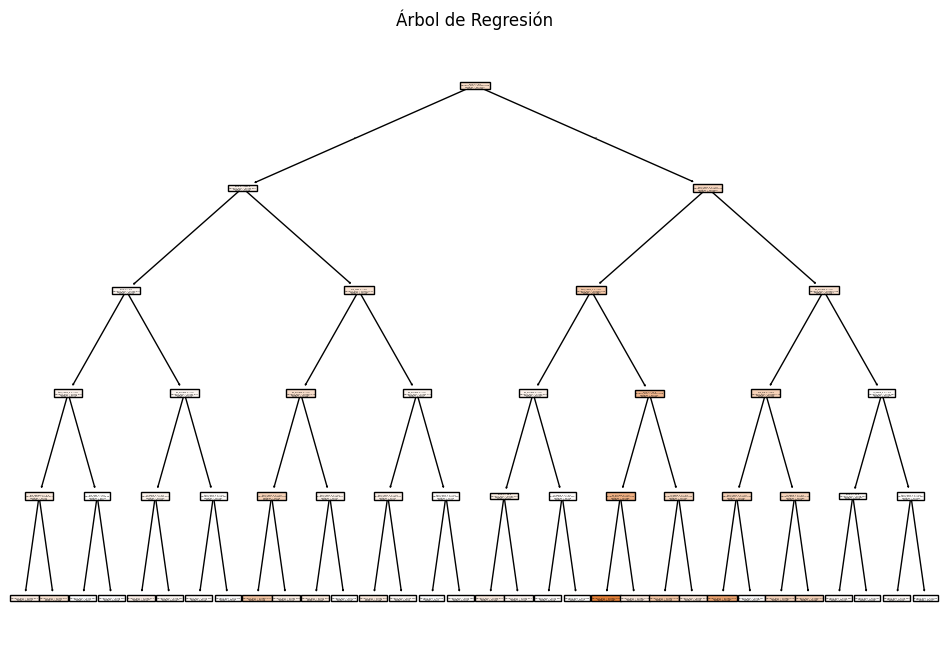

Iniciando predicciones por lotes...
Procesado lote 1/448
Procesado lote 2/448
Procesado lote 3/448
Procesado lote 4/448
Procesado lote 5/448
Procesado lote 6/448
Procesado lote 7/448
Procesado lote 8/448
Procesado lote 9/448
Procesado lote 10/448
Procesado lote 11/448
Procesado lote 12/448
Procesado lote 13/448
Procesado lote 14/448
Procesado lote 15/448
Procesado lote 16/448
Procesado lote 17/448
Procesado lote 18/448
Procesado lote 19/448
Procesado lote 20/448
Procesado lote 21/448
Procesado lote 22/448
Procesado lote 23/448
Procesado lote 24/448
Procesado lote 25/448
Procesado lote 26/448
Procesado lote 27/448
Procesado lote 28/448
Procesado lote 29/448
Procesado lote 30/448
Procesado lote 31/448
Procesado lote 32/448
Procesado lote 33/448
Procesado lote 34/448
Procesado lote 35/448
Procesado lote 36/448
Procesado lote 37/448
Procesado lote 38/448
Procesado lote 39/448
Procesado lote 40/448
Procesado lote 41/448
Procesado lote 42/448
Procesado lote 43/448
Procesado lote 44/448
Proce

c:\Users\Guadalupe\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


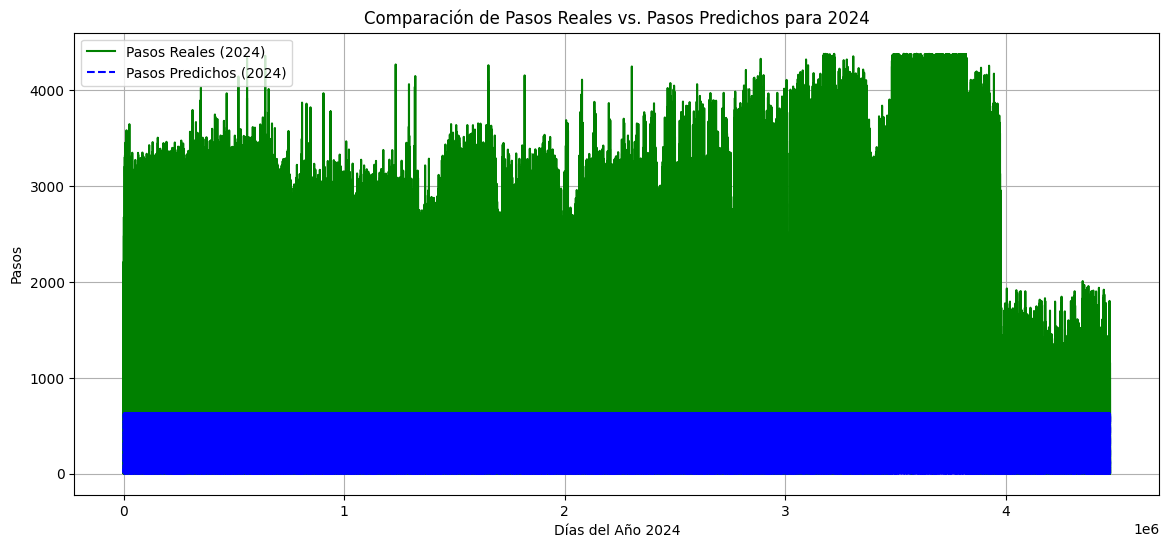

In [18]:
# Seleccionar solo las columnas más relevantes para reducir el uso de memoria
# cols1 =['hora', 'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 'hacia_provincia', 'es_pesado', 'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3', 'nro_dia', 'nro_mes', 'anio', 'dia_semana']  
# cols = ['hora', 'nro_dia', 'nro_mes', 'anio', 'dia_semana']
# x = dataset[cols1]  
# y = dataset['pasos'] 
import math
# Definir X con todas las columnas excepto la columna de destino 'pasos'
x = dataset.drop(columns=['pasos'])
y = dataset['pasos']

dataset_2024 = procesar_dataset("2024_data.csv")
# Dividir en conjunto de entrenamiento y de prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=14)
x_train_reduced = pca.fit_transform(x_train)
x_test_reduced = pca.transform(x_test)

# Crear y entrenar el modelo de regresión
regressor = DecisionTreeRegressor(
    random_state=42,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features="sqrt"
)

# Entrenar el regresor
regressor.fit(x_train, y_train)

def predict_in_batches(model, data, batch_size=10000):
    """
    Realiza predicciones de regresión en lotes para evitar problemas de memoria.
    
    Args:
        model: Modelo entrenado (DecisionTreeRegressor)
        data: DataFrame con los datos a predecir
        batch_size: Tamaño del lote para procesar
        
    Returns:
        numpy.array con todas las predicciones
    """
    predictions = []
    
    # Calcular número de lotes
    n_batches = math.ceil(len(data) / batch_size)
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(data))
        
        # Obtener el lote actual
        batch = data.iloc[start_idx:end_idx]
        
        # Realizar predicciones para este lote
        batch_predictions = model.predict(batch)
        
        # Guardar predicciones
        predictions.extend(batch_predictions)
        
        # Mostrar progreso
        print(f"Procesado lote {i+1}/{n_batches}")
    
    return np.array(predictions)

try:
    # Visualizar el árbol de regresión
    plt.figure(figsize=(12, 8))
    plot_tree(regressor, feature_names=x.columns, filled=True)
    plt.title("Árbol de Regresión")
    plt.show()

    # Cargar y procesar el dataset de 2024
    
    x_2024 = dataset_2024[x.columns].astype(np.float32)
    
    # Realizar predicciones usando la función de lotes
    print("Iniciando predicciones por lotes...")
    y_pred_2024 = predict_in_batches(regressor, x_2024, batch_size=10000)
    
    # Obtener valores reales
    y_real_2024 = dataset_2024['pasos']
    
    # Calcular métricas de evaluación
    mae = mean_absolute_error(y_real_2024, y_pred_2024)
    rmse = math.sqrt(root_mean_squared_error(y_real_2024, y_pred_2024))
    
    print(f"\nMétricas de evaluación:")
    print(f"Error Absoluto Medio (MAE): {mae:.2f}")
    print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
    
    # Visualizar las predicciones vs valores reales
    plt.figure(figsize=(14, 6))
    plt.plot(y_real_2024.values, label="Pasos Reales (2024)", color='green')
    plt.plot(y_pred_2024, label="Pasos Predichos (2024)", color='blue', linestyle='--')
    plt.title("Comparación de Pasos Reales vs. Pasos Predichos para 2024")
    plt.xlabel("Días del Año 2024")
    plt.ylabel("Pasos")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error durante la ejecución: {str(e)}")

MAE: 171.60
RMSE: 19.73


c:\Users\Guadalupe\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


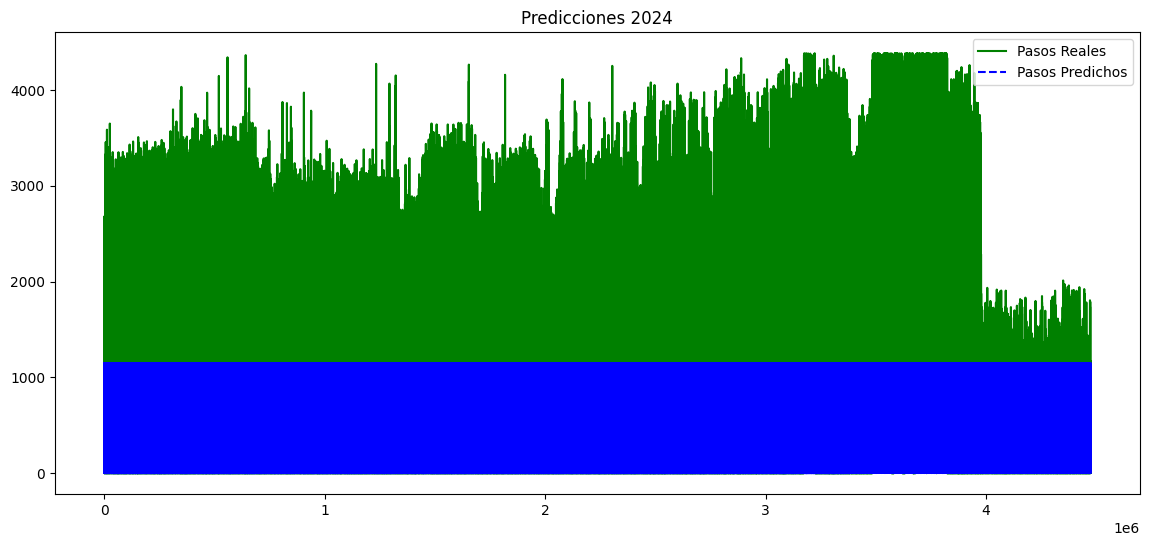

In [19]:
# Preparación de datos
x = dataset.drop(columns=['pasos'])
y = dataset['pasos']

# División de datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

# Modelo de Regresión
regressor = DecisionTreeRegressor(
    random_state=42,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10
)

# Entrenamiento
regressor.fit(x_train, y_train)

# Predicción en 2024
x_2024 = dataset_2024[x.columns]
y_pred_2024 = regressor.predict(x_2024)

# Evaluación
mae = mean_absolute_error(dataset_2024['pasos'], y_pred_2024)
rmse = np.sqrt(root_mean_squared_error(dataset_2024['pasos'], y_pred_2024))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualización
plt.figure(figsize=(14, 6))
plt.plot(dataset_2024['pasos'], label="Pasos Reales", color='green')
plt.plot(y_pred_2024, label="Pasos Predichos", color='blue', linestyle='--')
plt.title("Predicciones 2024")
plt.legend()
plt.show()

In [20]:
dataset = pd.read_csv("clean_data.csv")
dataset_2024 = pd.read_csv("2024_data.csv")

payment_codification = {
    'Efectivo': 0,
    'Exento': 1,
    'Monedero virtual': 2,
    'Rec.Deuda': 3,
    'Tarjeta Magnetica': 4,
    'Tag':5,
    'Infraccion': 6,
    'Otro': 7,
}
dataset_2024['tipo_cobro'] = dataset_2024['tipo_cobro'].replace(payment_codification)
dataset['tipo_cobro'] = dataset['tipo_cobro'].replace(payment_codification)

tolls = {
    'AVE': 0,
    'DEC': 1,
    'ALB': 2,
    'ILL': 3,
    'RET': 4,
    'SAL': 5,
    'SAR': 6,
}
dataset_2024['id_peaje'] = dataset_2024['id_peaje'].replace(tolls)
dataset['id_peaje'] = dataset['id_peaje'].replace(tolls)
direction = {
    'Centro': 0,
    'Provincia': 1,
}

dataset_2024['sentido'] = dataset_2024['sentido'].replace(direction)
dataset['sentido'] = dataset['sentido'].replace(direction)
day_encoding = {
        'Lunes': 0,
        'Martes': 1,
        'Miercoles': 2,
        'Jueves': 3,
        'Viernes': 4,
        'Sabado': 5,
        'Domingo': 6,
}

dataset_2024['dia'] = dataset_2024['dia'].replace(day_encoding)
dataset['dia'] = dataset['dia'].replace(day_encoding)

vehicle_type = {
    'Pesado': 0,
    'Liviano': 1,
}
dataset_2024['tipo_vehiculo'] = dataset_2024['tipo_vehiculo'].replace(vehicle_type)
dataset['tipo_vehiculo'] = dataset['tipo_vehiculo'].replace(vehicle_type)

dataset['fecha'] = pd.to_datetime(dataset['fecha'])
dataset_2024['fecha'] = pd.to_datetime(dataset_2024['fecha'])

dataset['fecha'] = (pd.to_datetime(dataset['fecha']) - pd.to_datetime(dataset['fecha'].dt.year.astype(str) + '-01-01')).dt.days + 1
dataset_2024['fecha'] = (pd.to_datetime(dataset_2024['fecha']) - pd.to_datetime(dataset_2024['fecha'].dt.year.astype(str) + '-01-01')).dt.days + 1

C:\Users\Guadalupe\AppData\Local\Temp\ipykernel_7980\997607911.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset_2024['tipo_cobro'] = dataset_2024['tipo_cobro'].replace(payment_codification)
C:\Users\Guadalupe\AppData\Local\Temp\ipykernel_7980\997607911.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['tipo_cobro'] = dataset['tipo_cobro'].replace(payment_codification)
C:\Users\Guadalupe\AppData\Local\Temp\ipykernel_7980\997607911.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will 

Correlación de cada variable con 'pasos':
tipo_vehiculo    0.224693
id_peaje         0.112984
hora             0.061210
sentido          0.047437
tipo_cobro       0.046698
dia              0.018231
fecha            0.011071
Name: pasos, dtype: float64
Variable: tipo_vehiculo
 - MSE: 211655.08054691763
 - R^2: 0.050691928514959184

Variable: id_peaje
 - MSE: 220061.91601536138
 - R^2: 0.012985879856839189

Variable: hora
 - MSE: 222131.81843800016
 - R^2: 0.0037020248606824957

Variable: sentido
 - MSE: 222429.08558738753
 - R^2: 0.0023687324890957484

Variable: tipo_cobro
 - MSE: 222462.83143562442
 - R^2: 0.0022173767738083994

Variable: dia
 - MSE: 222888.4062681178
 - R^2: 0.00030860320474057623

Variable: fecha
 - MSE: 222932.0788791256
 - R^2: 0.0001127243152502233

La mejor variable predictiva para 'pasos' según el MSE es: tipo_vehiculo
MSE: 211655.08054691763
R^2: 0.050691928514959184


c:\Users\Guadalupe\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


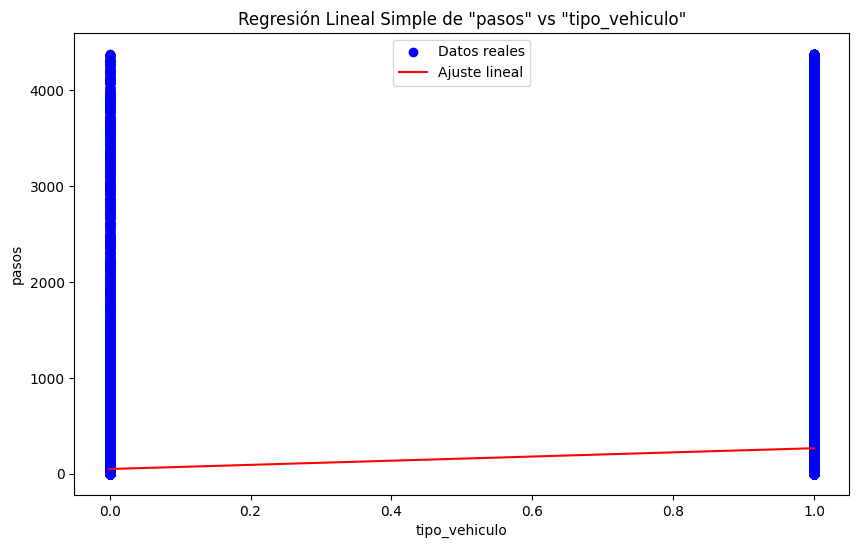

In [21]:

# Asegúrate de que la columna 'fecha' esté en formato datetime
dataset_2024['fecha'] = pd.to_datetime(dataset_2024['fecha'], format='%Y-%m-%d', errors='coerce')
# Calcular la correlación entre cada variable y 'pasos'
correlation_with_target = dataset.corr()['pasos'].drop('pasos')
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)


print("Correlación de cada variable con 'pasos':")
print(correlation_with_target)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Inicializar diccionarios para almacenar métricas
mse_scores = {}
r2_scores = {}

for variable in correlation_with_target.index:
    # Preparar datos de entrenamiento y prueba para la variable actual
    x = dataset[[variable]]  # Seleccionar la variable como DataFrame de una sola columna
    y = dataset['pasos']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)
    
    # Crear y entrenar el modelo de regresión lineal simple
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    # Predecir sobre el conjunto de prueba
    y_pred = model.predict(x_test)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Guardar métricas
    mse_scores[variable] = mse
    r2_scores[variable] = r2
    
    print(f"Variable: {variable}")
    print(f" - MSE: {mse}")
    print(f" - R^2: {r2}\n")
    
    # Mostrar la variable con mejor ajuste
best_variable = min(mse_scores, key=mse_scores.get)
print(f"La mejor variable predictiva para 'pasos' según el MSE es: {best_variable}")
print(f"MSE: {mse_scores[best_variable]}")
print(f"R^2: {r2_scores[best_variable]}")


import matplotlib.pyplot as plt

# Crear los datos de entrenamiento y prueba para la mejor variable
x_best = dataset[[best_variable]]
x_train_best, x_test_best, y_train, y_test = train_test_split(x_best, y, test_size=0.2, random_state=50)

# Entrenar el modelo con la mejor variable
best_model = LinearRegression()
best_model.fit(x_train_best, y_train)

# Hacer predicciones
y_pred_best = best_model.predict(x_test_best)

# Visualizar el ajuste lineal
plt.figure(figsize=(10, 6))
plt.scatter(x_test_best, y_test, color='blue', label='Datos reales')
plt.plot(x_test_best, y_pred_best, color='red', label='Ajuste lineal')
plt.xlabel(best_variable)
plt.ylabel('pasos')
plt.title(f'Regresión Lineal Simple de "pasos" vs "{best_variable}"')
plt.legend()
plt.show()

